# Linear Discriminant Analysis Model
### This is a project made to practice _NU CIT-651_ machine learning course's curriculum.

In this project, a LDAModel class was created from scratch. It can be used to project data points C-1 reduced dimensions where C is the number of classes as long as C <= 3. It can also classify new points regardless of C and number of features. However higher values will affect accuracy.

The model uses Fisher's Linear Analysis to reduce the number of dimensions in the input data then classifies the data using a generative guassian model.

In [1]:
import numpy as np
from LDAModel import LDAModel
import matplotlib.pylab as plt
%matplotlib inline

## Testing the model on a two-class, two-feature dataset
This dataset was provided during one of the courses labs. We will import the training data points as **_train_data_** and their labels as **_train_lbls_**.

We will then instantiate our class and make a classifier object called _**classifier**_, passing our training data and labels to the `__init__` method. This will train our classifier object.


In [2]:
Data=np.loadtxt('Data1.txt')
train_data = Data[:,0:2]
train_lbls = Data[:,2]
classifier = LDAModel(train_data,train_lbls)

Now we will import the test data points as **_test_data_** and their labels as **_test_lbls_**.

We will use a method in the class called **_classify_** to get the model to classify our test data. We will name the labels that our model outputs simply _**t**_.


The points are clearly separated, we can see that Fisher's solution aims to maximize the distance between the classes means while minimizing the within class variance.

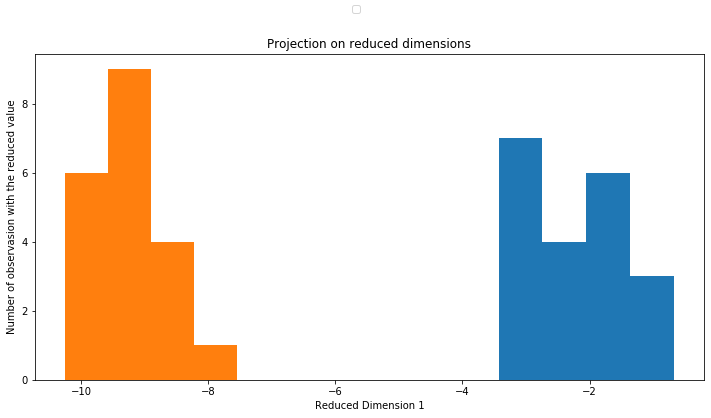

In [3]:
test_data = np.matrix(np.loadtxt('Test1.txt'))
test_lbls = classifier.classify(test_data)

## Testing the model on the Iris dataset.
We will use the Iris dataset (a three-class) for this test, We will import four features from the dataset :
1. Sepal Length in cm
2. Sepal Width in cm
3. Petal Length in cm
4. Petal Width in cm

We will import our points points as **_X_** and their labels as **_t_**.

In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

#Download the data into a pandas Dataframe
df = pd.io.parsers.read_csv(
    filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
    header=None,
    sep=',',
    )

#Picking out the desired features, and cleaning the data
feature_dict = {i:label for i,label in zip(
                range(4),
                  ('sepal length in cm',
                  'sepal width in cm',
                  'petal length in cm',
                  'petal width in cm', ))}
df.columns = [l for i,l in sorted(feature_dict.items())] + ['class label']
df.dropna(how="all", inplace=True) # to drop the empty line at file-end
X = df[["sepal length in cm", "sepal width in cm", "petal length in cm", "petal width in cm"]]

#Formating the data labels into three classes of (1, 2, 3)
t = df["class label"]
enc = LabelEncoder()
label_encoder = enc.fit(t)
t = label_encoder.transform(t) + 1
label_dict = {1: 'Setosa', 2: 'Versicolor', 3:'Virginica'}



Using Sci-Kit learn's method `train_test_split`, we will divide **_X_** and **_t_** into **_train_data_**, **_train_lbls_**. and **_test_data_**, **_test_lbls_**. We will use a 80% - 20% split.
We will then instantiate our class and make a classifier object called _**classifier**_, passing our training data and labels to the `__init__` method. This will train our classifier object. 
The class will identify that the data has three classes and will use different methods to accomodate this change.

In [5]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_lbls, test_lbls = train_test_split(X, t, test_size = 0.2, random_state = 100)

classifier = LDAModel(train_data,train_lbls)

Since this is a dataset with three classes, Fisher's algorithm will produce two reduced dimensions. we will represent the workings of our model graphically by making a scatter plot of our two reduced dimensions with their correspoding projections in the form of a histogram. 

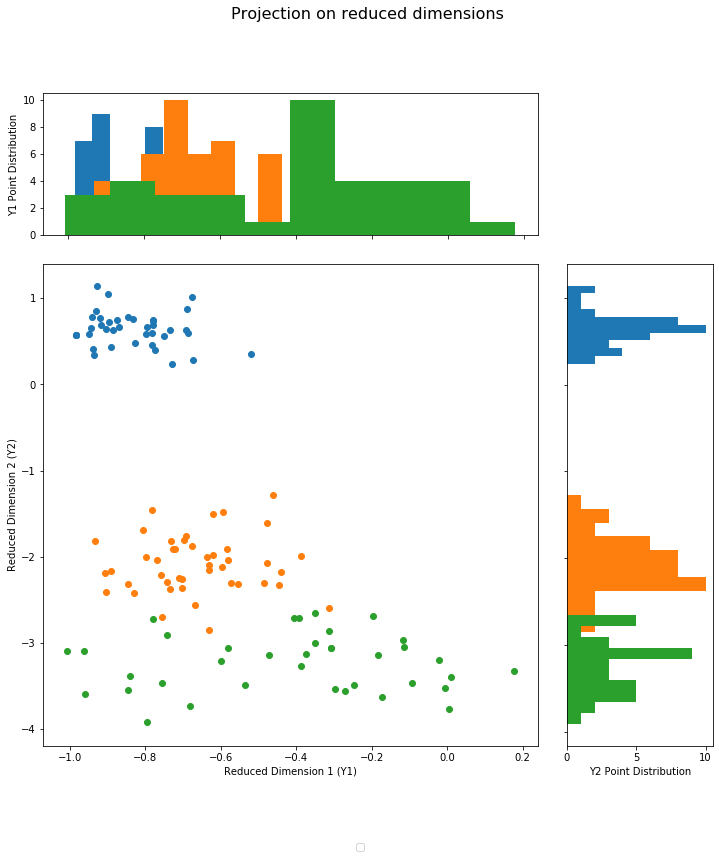

In [6]:
t = classifier.classify(test_data)

f = classifier.project_on_reduced_dimensions(test_data,t)

Next, we can measure the accuracy of our predicted labels _**t**_ by matching them with the test labels that we imported **_test_lbls_**.

Accuracy comes out at **100%**

In [7]:
Accuracy = 100*np.sum(t == test_lbls)/len(test_lbls)
print(f"Accuracy of predicted labels = {Accuracy}%")

Accuracy of predicted labels = 100.0%


## Testing the model on the MINST dataset
MINST is a database of handwritten numbers ranging from 0 to 9. Each number comes in the form of a 28x28 image, giving our model 784 features to consider.

We will load MINST from Keras because it has the full 60,000 entry database.

In [8]:
from keras.datasets import mnist
(trainX, trainy), (testX, testy) = mnist.load_data()

def flatten(images):
    length_of_flattened_image = images.shape[1]*images.shape[2]
    image_array=np.zeros((images.shape[0],length_of_flattened_image))
    for i in range(len(images)):
        image_array[i,:]=images[i].reshape((1,length_of_flattened_image))
    return image_array


trainX = flatten(trainX)
testX = flatten(testX)

Using TensorFlow backend.


Our model will reduce this data to k-1 dimesnions where k is the number of classes. According to Fisher's algorithm, the dimensions with the most separation {J(w)} are the dimensions whose weight vectors correspond to the highest eigen values if j(w) is solved as a generalized eigen problem.

We will take the three eigen vectors corresponding to the highest three eigen values and use them to project our test points on the three most optimized reduced dimensions.

We can see that some degree of separation is already visible with only three dimensions. However, when classifying the model will consider the maximum number of dimension available, 9 dimensions in this case.

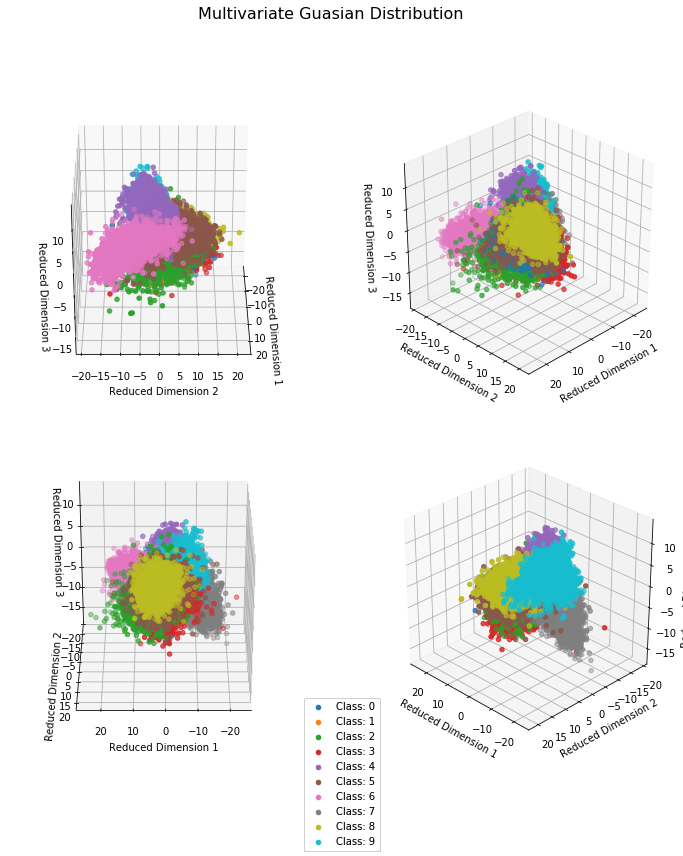

In [9]:
classifier = LDAModel(trainX, trainy)
t = classifier.classify(testX)

To improve separation and speed up processing time, we will try to pre-process our images.
below are 4 functions we will use to reduce our images to 20x20 black and white images, for maximum contrast. we will also drop every pixel that does not change at all across the whole dataset.

In [10]:
def center(image):
   mask = image>95
   image = image[np.ix_(mask.any(1),mask.any(0))]
   shortest_dimension = min(image.shape)
   compensation = 14 - np.floor((shortest_dimension)//2)
   return np.pad(image, pad_width = int(compensation), mode = 'constant', constant_values = 0)


def crop(images,cropx,cropy):
  no_of_images = images.shape[0]
  images_cropped = np.empty((no_of_images , cropx * cropy) , dtype = int)
  for i in range(no_of_images):
    image = images[i,:].reshape(28,28)
    image = center(image)
    dimensions = image.shape
    startx = (dimensions[1] - cropx)//2
    starty = (dimensions[0]-cropy)//2
    cropped_image = image[starty:starty+cropy:,startx:startx+cropx].reshape(1, cropx * cropy)
    images_cropped[i,:] = cropped_image
  return images_cropped

def drop_constant_pixels(images):
    comparison = images == images[0,:]
    constant_columns = comparison.all(axis = 0)
    return images[:, ~constant_columns]


V_black_n_white = np.vectorize(lambda x: 0 if x< 120 else 1)

def pre_process(images,cropx,cropy):
    return V_black_n_white(drop_constant_pixels(crop(images,cropx,cropy)))

We can see below how our the images look like before the final run of our classifier.

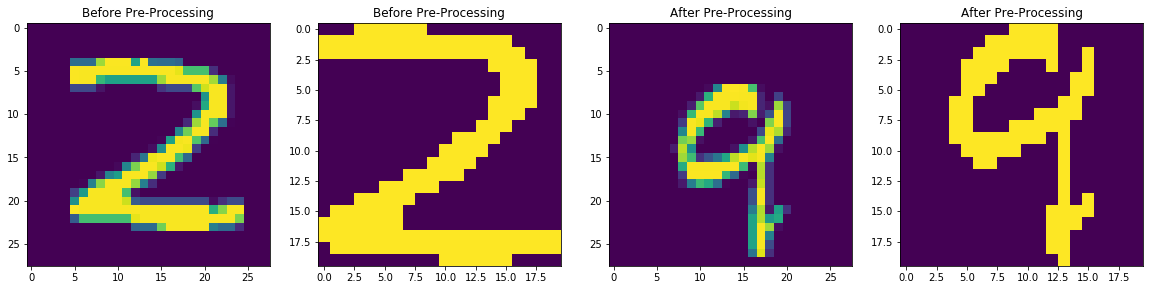

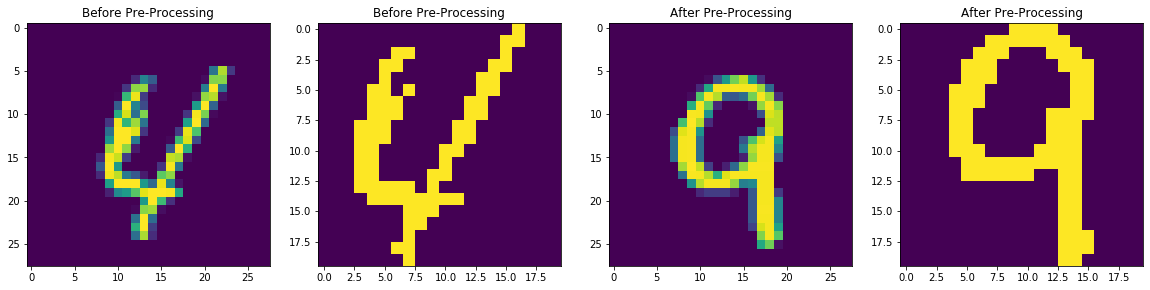

In [11]:
trainX_processed = pre_process(trainX,23,23)
testX_processed = pre_process(testX,23,23)

new_dimension = int(trainX_processed.shape[1]**.5)
plt.rcParams["figure.figsize"] = (20,10)
for i in range(1,4,2):
    axes = [plt.subplot(1, 4, i) for i in range(1,5)]
    
    axes[0].imshow(trainX[-20+i*240,:].reshape(28,28))
    axes[1].imshow(trainX_processed[-20+i*240,:].reshape(new_dimension,new_dimension))
    axes[2].imshow(trainX[-20+(i+1)*240,:].reshape(28,28))
    axes[3].imshow(trainX_processed[-20+(i+1)*240,:].reshape(new_dimension,new_dimension))
    
    for i in range(0,4):
        axes[i].set_title('Before Pre-Processing') if i//2 == 0 else axes[i].set_title('After Pre-Processing')
        
    plt.show()

Running our classifier on the pre-processed data reveals supperior separation, and the one to one classification accuracy in this dataset is 84.79%.

Accuracy of predicted labels = 84.79%


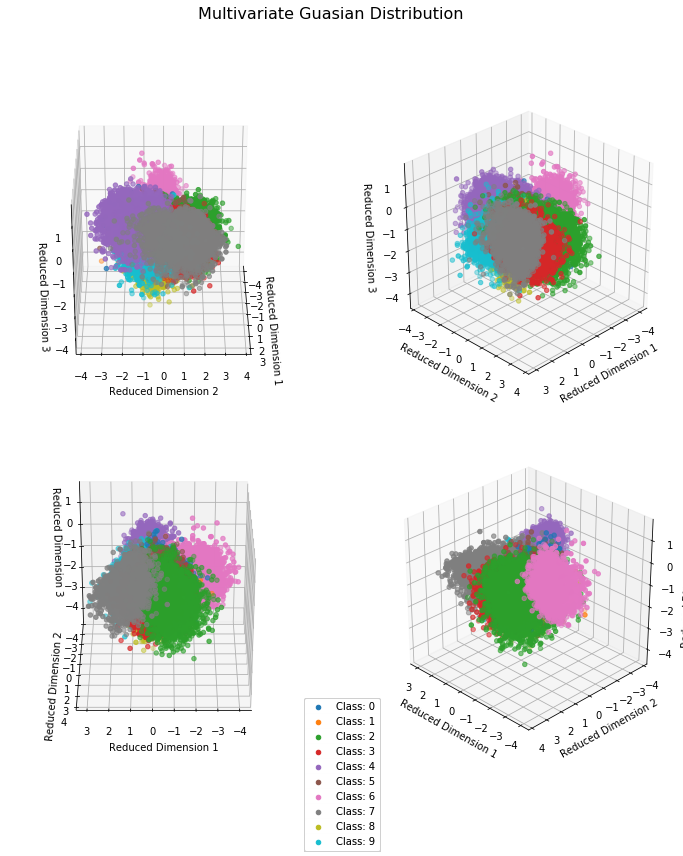

In [12]:
classifier = LDAModel(trainX_processed, trainy)
t = classifier.classify(testX_processed)
Accuracy = 100*np.sum(t == testy)/len(testy)
print(f"Accuracy of predicted labels = {Accuracy}%")

We can further analyze the performance of our model below.

In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

cm = confusion_matrix(testy, t)

print('Confusion Matrix: ')
print(cm)
print('\n')
print('Accuracy Score :',accuracy_score(testy, t))
print('\n')
print('Report : ')
print(classification_report(testy, t))

Confusion Matrix: 
[[ 774    1   16   13   21   90   45    4   13    3]
 [   6 1041   12    0   15    4    5    3   48    1]
 [  59   12  835   34   11    3   14    9   55    0]
 [  22    9   16  874    1   37    0   18   22   11]
 [   1    3   10    0  875    2   23    0   10   58]
 [ 129    1    6   37   19  651    6    4   31    8]
 [  13    2   17    2    7   20  886    0   11    0]
 [   1   21   15    4   18    4    0  890   19   56]
 [  41   27    9   22   21   33    6    9  775   31]
 [   8    7    4   10   48    9    0   19   26  878]]


Accuracy Score : 0.8479


Report : 
              precision    recall  f1-score   support

           0       0.73      0.79      0.76       980
           1       0.93      0.92      0.92      1135
           2       0.89      0.81      0.85      1032
           3       0.88      0.87      0.87      1010
           4       0.84      0.89      0.87       982
           5       0.76      0.73      0.75       892
           6       0.90      0.92

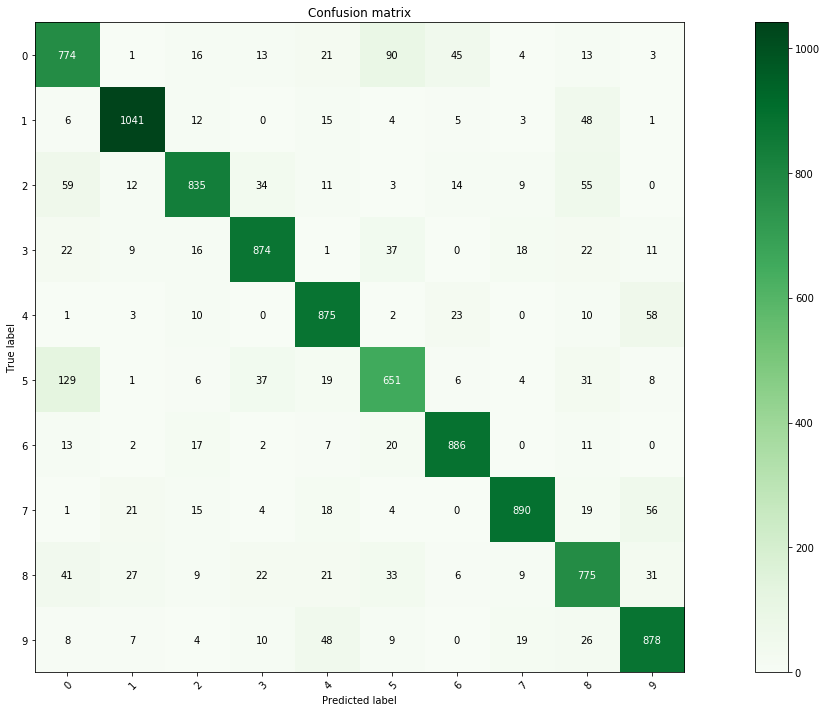

In [14]:
plt.rcParams["figure.figsize"] = (20,10)
title = 'Confusion matrix'

cmap = plt.cm.Greens
classes = np.unique(testy)

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title=title,
       ylabel='True label',
       xlabel='Predicted label')

ax.margins(y = 5)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()